<a href="https://colab.research.google.com/github/EJLEE5826/cau_deep_learning_2025/blob/main/2%EC%A3%BC%EC%B0%A8_Linear_Classifier_answer_250912.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd /content/drive/

In [ ]:

! cd /content/drive/MyDrive/deep_learning_implementing/

### CIFAR-10 dataset   
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.   
There are 50000 training images and 10000 test images.

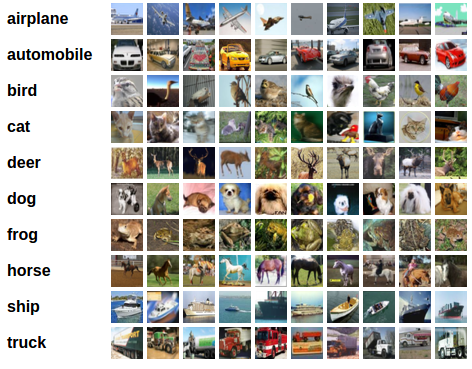

**Training a Nearest Neighbor Classifier**

### Nearest Neighbor Classifier.

새로운 데이터를 입력 받았을 때 학습 데이터에서 가장 가까이 있는 것이 무엇이냐를 중심으로 새로운 데이터의 label을 정해주는 알고리즘

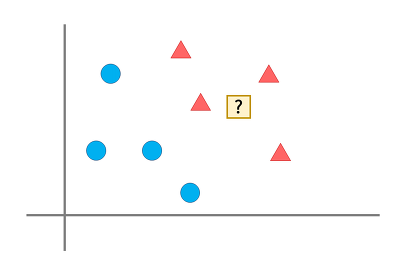

###k-Nearest Neighbor
학습 데이터에서 가장 가까운 단일 데이터를 보는 것 대신 가장 가까운 상위 K개의 데이터를 보고 새로운 데이터의 label을 설정해주는 알고리즘  
K는 hyperparameter  

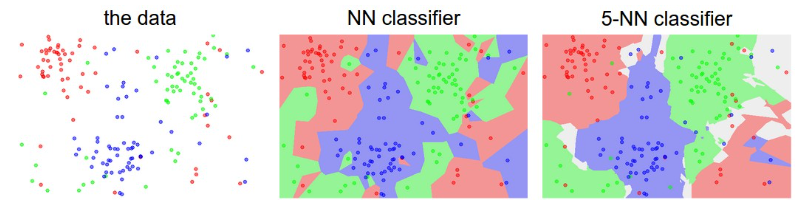   
The kNN classifier consists of two stages:

* During training, the classifier takes the training data and simply remembers it
* During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
* The value of k is cross-validated


**Load and normalize CIFAR10**

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms


CIFAR-10 데이터 셋 설정

In [ ]:
# 데이터 변환 파이프라인 정의: 이미지를 텐서로 변환하고, 각 채널을 0.5로 정규화
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 배치 사이즈 설정
batch_size = 4

# CIFAR10 학습 데이터셋 로드 (이미지 변환 적용)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# 학습 데이터 로더 설정
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# CIFAR10 테스트 데이터셋 로드 (이미지 변환 적용)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# 테스트 데이터 로더 설정
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


In [ ]:
# CIFAR10 데이터셋의 클래스 정의
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

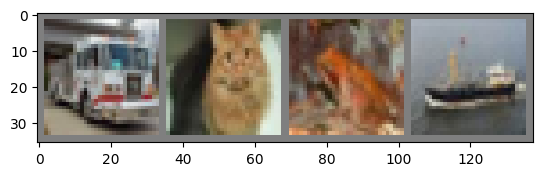

truck cat   frog  ship 


In [ ]:
# 이미지를 화면에 보여주는 함수 정의 (unnormalize)
def imshow(img):
    img = img / 2 + 0.5     # 정규화된 이미지를 원래 값으로 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (C, H, W) -> (H, W, C)로 변환하여 표시
    plt.show()


# 랜덤 학습 이미지 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지를 화면에 보여줌
imshow(torchvision.utils.make_grid(images))
# 라벨 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# 학습 데이터셋과 테스트 데이터셋을 각각 배열로 변환하기 위해 리스트 초기화
X_train, y_train = [], []
X_test, y_test = [], []

# 학습 데이터셋을 이미지 데이터를 numpy 배열로 변환하여 X_train과 y_train에 저장
for i, (X, y) in enumerate(trainset):
    X_train.append(np.array(X))
    y_train.append(np.array(y))

In [ ]:
# 학습 데이터셋 크기 출력
print(len(X_train))
X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

50000
(50000, 3, 32, 32)
(50000,)


In [ ]:
# 테스트 데이터셋을 이미지 데이터를 numpy 배열로 변환하여 X_test와 y_test에 저장
for i, (X, y) in enumerate(testset):
    X_test.append(np.array(X))
    y_test.append(np.array(y))

print(len(X_test))
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape)
print(y_test.shape)

10000
(10000, 3, 32, 32)
(10000,)


In [ ]:
# 효율성을 위한 데이터 샘플링
num_training = 5000
mask = range(num_training)  # 5000개의 샘플을 선택할 마스크 생성
X_train_sub = X_train[mask] # 학습 데이터에서 일부 샘플링
y_train_sub = y_train[mask] # 학습 라벨에서 일부 샘플링

# 테스트 데이터 일부를 샘플링
num_test = 500
mask = range(num_test) # 500개의 샘플을 선택할 마스크 생성
X_test_sub = X_test[mask] # 테스트 데이터에서 일부 샘플링
y_test_sub = y_test[mask] # 테스트 라벨에서 일부 샘플링

In [ ]:
# 이미지 데이터를 행렬 형태로 변환 (이미지를 1차원 벡터로 변환)
X_train_sub = np.reshape(X_train_sub, (X_train_sub.shape[0], -1))
X_test_sub = np.reshape(X_test_sub, (X_test_sub.shape[0], -1))
print(X_train_sub.shape, X_test_sub.shape)

(5000, 3072) (500, 3072)


**Distance Metric**
### L2 Distance
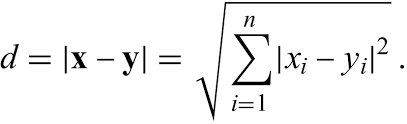

In [ ]:
class KNearestNeighbor(object):
    """ L2 거리를 사용하는 kNN 분류기 """
    def __init__(self):
         # 생성자 함수.
         self.X_train = None
         self.y_train = None

    def train(self, X, y):
        # kNN에서 학습은 별도의 모델 학습을 하지 않고 단순히 학습 데이터를 저장
        ##############
        self.X_train = X
        self.y_train = y
        ##############


    def predict(self, X, k=1):
        # 예측 함수, 주어진 데이터에 대해 가장 가까운 k개의 이웃을 찾아 예측

        # 두 개의 반복문을 사용해 L2 거리를 계산하는 함수 호출
        dists = self.compute_distances_two_loops(X)

        # 계산된 거리 행렬을 사용해 라벨 예측
        return self.predict_labels(dists, k=k)

    def compute_distances_two_loops(self, X):
        # 두 개의 반복문을 사용하여 테스트 데이터와 학습 데이터 사이의 L2 거리를 계산
        num_test = X.shape[0] # 테스트 데이터의 개수
        num_train = self.X_train.shape[0] # 학습 데이터의 개수

        # 거리 행렬 초기화, 각 테스트 데이터와 학습 데이터 사이의 거리를 저장할 배열
        dists = np.zeros((num_test, num_train))

         # 테스트 데이터와 학습 데이터의 거리를 계산하는 두 개의 반복문
        for i in range(num_test):
            for j in range(num_train):
                # L2 거리 계산 (유클리드 거리)
                ##############
                dists[i, j] = np.sqrt(np.sum((X[i, :] - self.X_train[j, :])**2))
                ##############

        # 계산된 거리 행렬 반환
        return dists

    def predict_labels(self, dists, k=1):
        # 주어진 거리 행렬을 사용해 예측할 라벨을 결정
        num_test = dists.shape[0] # 테스트 데이터의 개수
        y_pred = np.zeros(num_test) # 예측 결과를 저장할 배열 초기화

        # 각 테스트 샘플에 대해 가장 가까운 k개의 학습 샘플을 찾고 라벨을 예측
        for i in range(num_test):
            closest_y = []
            # 거리 행렬에서 가장 가까운 k개의 이웃의 인덱스 가져오기
            k_nearest_idxs = np.argsort(dists[i, :])[:k]
            # 가장 가까운 k개의 이웃의 라벨을 저장
            closest_y = self.y_train[k_nearest_idxs].flatten()

            # 가장 빈도가 높은 라벨을 예측값으로 선택
            y_pred[i] = np.argmax(np.bincount(closest_y))

        return y_pred

In [ ]:
# kNN 분류기 인스턴스 생성
classifier = KNearestNeighbor()
# 학습 데이터로 분류기 훈련
classifier.train(X_train_sub, y_train_sub)

In [ ]:
# 테스트 데이터와 학습 데이터 사이의 거리 계산
dists = classifier.compute_distances_two_loops(X_test_sub)
print(dists.shape)

(500, 5000)


In [ ]:
# 거리 행렬을 사용하여 테스트 데이터에 대한 라벨 예측
y_test_pred = classifier.predict_labels(dists, k=1)

In [ ]:
num_correct = np.sum(y_test_pred == y_test_sub.flatten())
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy*100))

Got 137 / 500 correct => accuracy: 27.400000


### K 값에 따른 정확도 계산

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# k 값에 따른 정확도 비교 함수
def evaluate_knn_for_k_range(k_values, classifier, X_train, y_train, X_test, y_test):
    accuracies = []

    # k 값에 따라 정확도 계산
    for k in k_values:
        print(f'Evaluating k={k}...')
        classifier.train(X_train, y_train)  # 학습 데이터로 훈련
        dists = classifier.compute_distances_two_loops(X_test)  # 거리 계산
        y_test_pred = classifier.predict_labels(dists, k=k)  # 라벨 예측
        num_correct = np.sum(y_test_pred == y_test.flatten())  # 정확도 계산
        accuracy = float(num_correct) / X_test.shape[0]
        accuracies.append(accuracy)  # 정확도 저장
        print(f'Accuracy for k={k}: {accuracy * 100:.2f}%')

    return accuracies

Evaluating k=1...
Accuracy for k=1: 27.40%
Evaluating k=3...
Accuracy for k=3: 27.20%
Evaluating k=5...
Accuracy for k=5: 27.80%
Evaluating k=7...
Accuracy for k=7: 27.40%
Evaluating k=9...
Accuracy for k=9: 26.80%
Evaluating k=11...
Accuracy for k=11: 26.20%
Evaluating k=13...
Accuracy for k=13: 26.60%
Evaluating k=15...
Accuracy for k=15: 27.20%


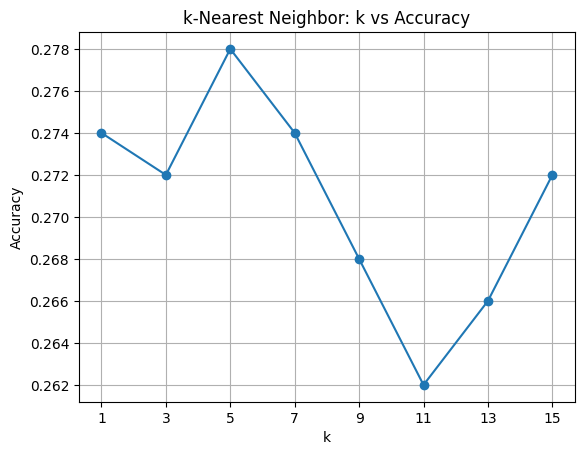

In [ ]:
# k 값 리스트 설정
k_values = [1, 3, 5, 7, 9, 11, 13, 15]

# k에 따른 정확도 계산
accuracies = evaluate_knn_for_k_range(k_values, classifier, X_train_sub, y_train_sub, X_test_sub, y_test_sub)

# 정확도 시각화
plt.plot(k_values, accuracies, marker='o')
plt.title('k-Nearest Neighbor: k vs Accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()